# <u>**Vivarium E. coli**<u/>

This notebook demonstrates features of the processes in the Vivarium *E. coli* model. First, we show distinct features of how the processes work individually. Then we combine the processes in our simulation to demonstrate how they work together. Finally, we run the entire model.

<u>**Future Directions:**</u>
- Demonstrate:
    1. Ecoli master partitioned
    2. Cell division
    3. Vivarium ecoli colonies

<u>**Miscellaneous notes/ideas:**</u>
- consider adding interactive widgets (plotly) - users can click boxes to choose which molecules to plot

In [1]:
# Make sure notebook runs out of vivarium-ecoli directory
import sys, os

# get the path to the notebook, and change working directory
notebook_path = sys.path[0][:sys.path[0].index('notebooks')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])
cwd = os.getcwd()
  
# print the current directory
print("Current working directory is:", cwd)

Current working directory is: /Users/eranagmon/code/vivarium-ecoli


# **1. Load the required components**

## module imports

In [2]:
from vivarium.core.process import Process
from vivarium.core.store import Store
from vivarium.core.engine import Engine, pp
from vivarium.core.composition import simulate_process, simulate_composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_variables
from ecoli.processes.registries import topology_registry
import ecoli
import copy

## Load sim_data

This unpickles and `sim_data` object, which holds model parameters from wcEcoli.
`LoadSimData` includes functions to retrieve individual processes' parameters, which can be modified and passed into their respective process models.

In [3]:
from ecoli.library.sim_data import LoadSimData

SIM_DATA_PATH = 'reconstruction/sim_data/kb/simData.cPickle'

load_sim_data = LoadSimData(
            sim_data_path=SIM_DATA_PATH,
            seed=0)

## Get initial state snapshot

`initial_state` is a dict with the initial state of the system -- a snapshot saved from wcEcoli.

In [4]:
from ecoli.composites.ecoli_master import get_state_from_file

INITIAL_STATE_PATH = 'data/wcecoli_t1000.json'

initial_state = get_state_from_file(path=INITIAL_STATE_PATH)

## Helper functions for executing the notebook

In [5]:
schema_keys = Store.schema_keys

def make_port_printout(ports_schema, depth=0, schema_show=5, filler_size=5):
    print_dict = ''
    filler = filler_size * ' '
    for port, schema in ports_schema.items():
        if isinstance(schema, dict):
            schemavars = list(schema.keys())
            if any(var in schemavars for var in schema_keys):
                print_schema = ''
                for k, v in schema.items():
                    print_schema += f'{(depth+1) * filler} {k}: {v}\n'
                print_dict += f'{depth * filler}{port}:\n{print_schema}\n'
            else:
                schema_items = schema.items()
                first_schema = dict(list(schema_items)[:schema_show])
                next_print = make_port_printout(first_schema, depth+1)
                print_dict += f'{port}:\n{next_print}\n'
                if len(schema) > schema_show:
                    print_dict += f'{(depth+1) * filler}'
                    print_dict += f'... skipping {len(schema)-schema_show} schema entries ...'
                    print_dict += f'\n\n'
        else:
            print_dict += f'{filler}{schema}\n'
    return print_dict

def find_increasing(d):
    for key, value in d.items():
        if value[-1] > value[0]:
            return {key: value}
    
def find_decreasing(d):
    for key, value in d.items():
        if value[-1] < value[0]:
            return {key: value}

# **2. Simulate Processes Individually**


Now we can load in our modular processes individually. For each process, we will:

1. Load in the process and parameters
2. Plot a **toplogy** diagram 
    - The topology is a network that demonstrates how a process connects to its stores (which hold state variables).
3. Display the **ports schema**
     - The port schema defines a systems ports (top-level keys), and the expected behavior of molecules under that port (its *schema*)
     - `*` is a wild card, specifies the schema of everything that can go into the port
4. Simulate the process
5. Demonstrate distinct features of that process

## <u>Complexation<u/>

In [6]:
from ecoli.processes.complexation import Complexation
print(ecoli.processes.complexation.__doc__)


Complexation

Macromolecular complexation sub-model.

This process encodes molecular simulation of macromolecular complexation,
in which monomers are assembled into complexes. Macromolecular complexation
is done by identifying complexation reactions that are possible (which are
reactions that have sufﬁcient counts of all sub-components), performing one
randomly chosen possible reaction, and re-identifying all possible complexation
reactions. This process assumes that macromolecular complexes form spontaneously,
and that complexation reactions are fast and complete within the time step of the
simulation.



In [87]:
# load in parameters
cplx_config = load_sim_data.get_complexation_config()
cplx_config['time_step'] = 0.01

# initialize process and topology
complexation = Complexation(cplx_config)

cplx_topology = topology_registry.access(complexation.name)

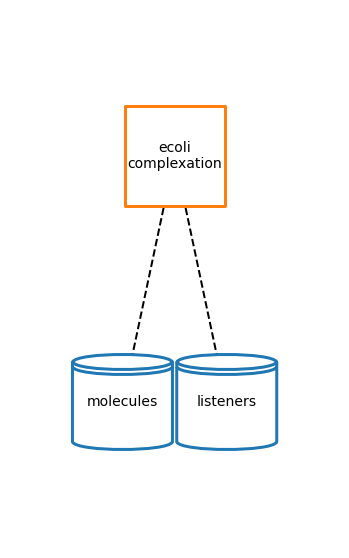

In [79]:
# plot topology
cplx_topology_plot_settings = {
    'buffer': 1,
    'node_labels': {
        'ecoli-complexation': 'ecoli\ncomplexation'
    },
    'show_ports': False,
    'node_size': 10000,
    'dashed_edges': True,
    'node_distance': 4,
}

cplx_topology_fig = plot_topology(complexation, cplx_topology_plot_settings)

In [9]:
# display ports schema
cplx_ports = complexation.ports_schema()
cplx_printout = make_port_printout(cplx_ports)
print(cplx_printout)

molecules:
     1-PFK[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     1-PFK-MONOMER[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     2OXOGLUTARATEDEH-CPLX[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     E1O[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     E2O[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


     ... skipping 2569 schema entries ...

listeners:
     complexation_events:
           _default: []
           _updater: set
           _emit: True





In [88]:
# tweak initial state
cplx_initial_state = copy.deepcopy(initial_state)
cplx_initial_state['bulk']['6PGLUCONDEHYDROG-MONOMER[c]'] = 1000

# run simulation and retrieve final data
cplx_settings = {
    'total_time': 0.1,
    'initial_state': cplx_initial_state,
    'topology': cplx_topology}

cplx_data = simulate_process(complexation, cplx_settings)


Simulation ID: 25555f76-1589-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:25:32
Completed in 0.225081 seconds


For complexation, let's look at the 6PGLUCONDEHYDROG-MONOMER[c] monomer as it transitions to the 6PGLUCONDEHYDROG-CPLX[c] complex:

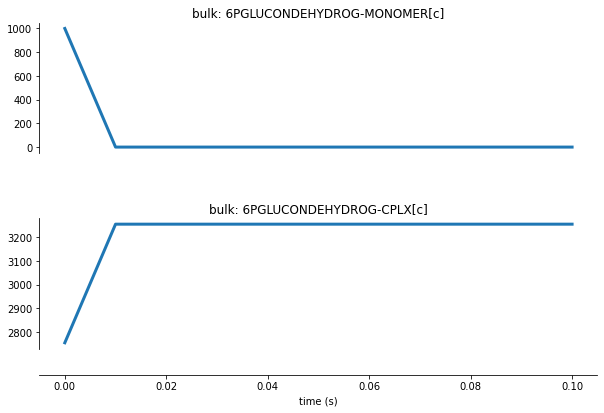

In [89]:
# plot output
cplx_fig = plot_variables(
    cplx_data, 
    variables=[
        ('bulk', '6PGLUCONDEHYDROG-MONOMER[c]'), 
        ('bulk', '6PGLUCONDEHYDROG-CPLX[c]'), 
    ],
    column_width=10, row_height=3, row_padding=0.5)

Here we see 6PGLUCONDEHYDROG-MONOMER[c] getting complexed. This a relatively fast process and consumes all the monomers in a single time step.

## <u>Transcript Initiation<u/>

In [12]:
from ecoli.processes.transcript_initiation import TranscriptInitiation
print(ecoli.processes.transcript_initiation.__doc__)


Transcript Initiation

Transcription initiation sub-model.

This process models the binding of RNA polymerase to each gene.
The number of RNA polymerases to activate in each time step is determined
such that the average fraction of RNA polymerases that are active throughout
the simulation matches measured fractions, which are dependent on the
cellular growth rate. This is done by assuming a steady state concentration
of active RNA polymerases.



In [13]:
# load in parameters
ti_params = load_sim_data.get_transcript_initiation_config()

# initialize process and topology
transcript_initiation = TranscriptInitiation(ti_params)

ti_topology = topology_registry.access(transcript_initiation.name)

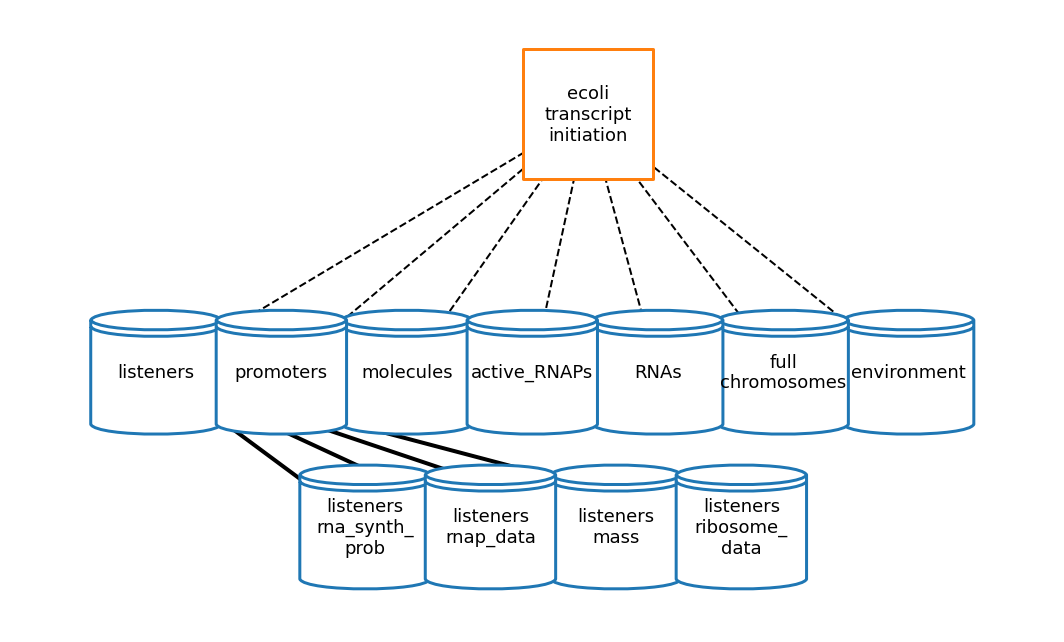

In [14]:
# plot topology
ti_topology_plot_settings = {
    'node_labels': {
        'ecoli-transcript-initiation': 'ecoli\ntranscript\ninitiation',
        'full_chromosomes': 'full\nchromosomes',
        'listeners\nrna_synth_prob': 'listeners\nrna_synth_\nprob',
        'listeners\nribosome_data': 'listeners\nribosome_\ndata',
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-transcript-initiation': (4, 2)}
}

ti_topology_fig = plot_topology(transcript_initiation, ti_topology_plot_settings)

In [15]:
# display ports schema
ti_ports = transcript_initiation.ports_schema()
ti_printout = make_port_printout(ti_ports)
print(ti_printout)

environment:
     media_id:
           _default: 
           _updater: set


molecules:
     APORNAP-CPLX[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     GUANOSINE-5DP-3DP[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


full_chromosomes:
*:
          unique_index:
                _default: 0



promoters:
*:
          TU_index:
                _default: 0

          coordinates:
                _default: 0

          domain_index:
                _default: 0

          bound_TF:
                _default: 0



RNAs:
*:
          unique_index:
                _default: 0
                _updater: set

          TU_index:
                _default: 0
                _updater: set

          transcript_length:
                _default: 0
                _updater: set
                _emit: True

          is_mRNA:
                _

In [16]:
# run simulation and retrieve final data
ti_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': ti_topology}

ti_data = simulate_process(transcript_initiation, ti_settings)


Simulation ID: b3115cc6-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:21
Completed in 1.80 seconds


For Transcript Initiation, we can see from the cell above that each active RNA polymerase molecule is represented by an ID number. Let's analyze how one of these active RNA polymerase molecules functions within this process:

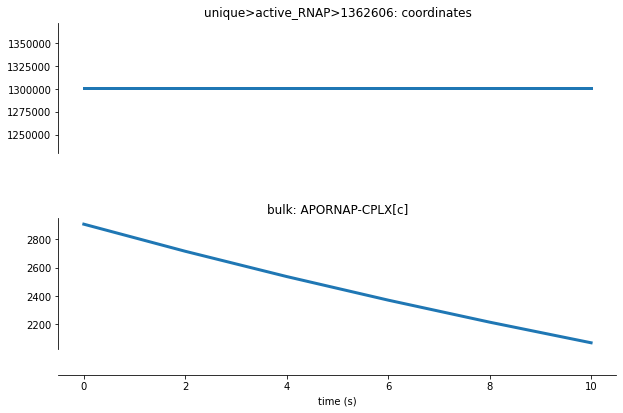

In [17]:
# plot output
RNAP_ID = list(ti_data['unique']['active_RNAP'].keys())[0] 

ti_fig = plot_variables(
    ti_data, 
    variables=[
        ('unique', 'active_RNAP', RNAP_ID, 'coordinates'),
        ('bulk', 'APORNAP-CPLX[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

Here we can see that the coordinates for one RNA polymerase molecule is initialized at time=0 and remains the same throughout the simulation as elongation is not a function of this process. Additionally, we can see that the RNA polymerase molecules (given by APORNAP-CPLX[c]) are getting deleted from the bulk molecules count as they bind to the DNA sequence and are initialized for transcription.

## <u>Transcript Elongation<u/>

In [18]:
from ecoli.processes.transcript_elongation import TranscriptElongation
print(ecoli.processes.transcript_elongation.__doc__)


Transcript Elongation

Transcription elongation sub-model.

This process models nucleotide polymerization into RNA molecules
by RNA polymerases. Polymerization occurs across all polymerases
simultaneously and resources are allocated to maximize the progress
of all polymerases up to the limit of the expected polymerase elongation
rate and available nucleotides. The termination of RNA elongation occurs
once a RNA polymerase has reached the end of the annotated gene.



In [19]:
# load in parameters
te_params = load_sim_data.get_transcript_elongation_config()

# initialize process and topology
transcript_elongation = TranscriptElongation(te_params)

te_topology = topology_registry.access(transcript_elongation.name)

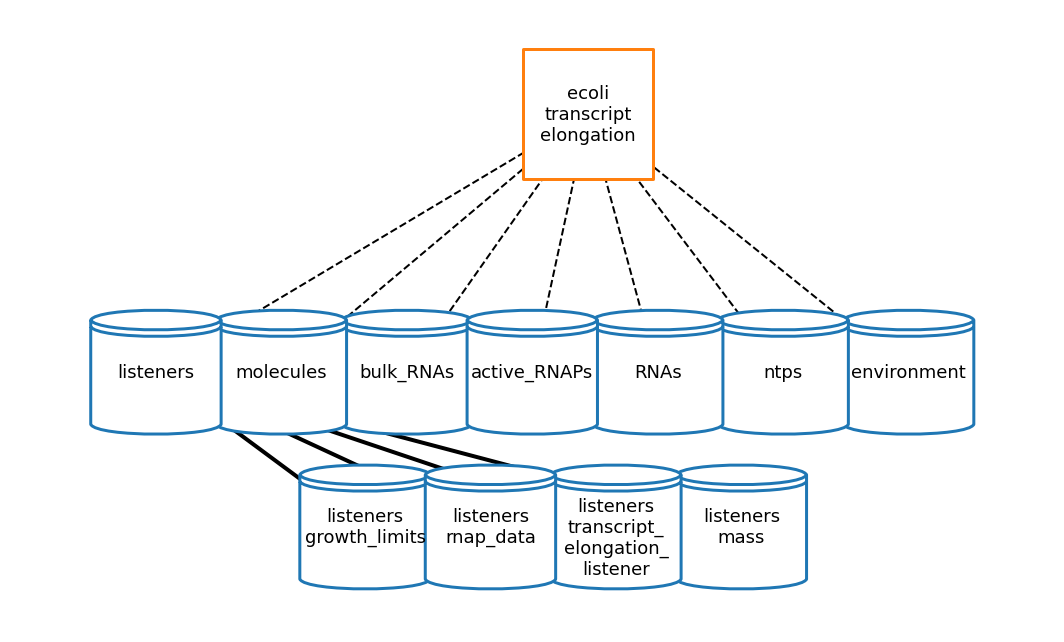

In [20]:
# plot topology
te_topology_plot_settings = {
    'node_labels': {
        'ecoli-transcript-elongation': 'ecoli\ntranscript\nelongation',
        'listeners\ntranscript_elongation_listener': '\nlisteners\ntranscript_\nelongation_\nlistener'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-transcript-elongation': (4, 2)}
}

te_topology_fig = plot_topology(transcript_elongation, te_topology_plot_settings)

In [21]:
# display ports schema
te_ports = transcript_elongation.ports_schema()
te_printout = make_port_printout(te_ports)
print(te_printout)

environment:
     media_id:
           _default: 


RNAs:
_divider:
     <function divide_RNAs_by_domain at 0x1326821f0>
topology:
     ('..', 'active_RNAP')


*:
          unique_index:
                _default: 0
                _updater: set

          TU_index:
                _default: 0
                _updater: set

          transcript_length:
                _default: 0
                _updater: set
                _emit: True

          is_mRNA:
                _default: False
                _updater: set

          is_full_transcript:
                _default: False
                _updater: set


          ... skipping 3 schema entries ...


active_RNAPs:
_divider:
     <function divide_active_RNAPs_by_domain at 0x132677ee0>

*:
          unique_index:
                _default: 0
                _updater: set

          domain_index:
                _default: 0
                _updater: set

          coordinates:
                _default: 0
                _updater: set
 

In [22]:
# run simulation and retrieve final data
te_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': te_topology}

te_data = simulate_process(transcript_elongation, te_settings)


Simulation ID: b54338ac-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:25
Completed in 2.39 seconds


For Transcript Elongation, we can see from the cell above that each active RNA Polymerase molecule is represented by an ID number. Let's analyze how a few of these active RNA Polymerase molecules function within this process:

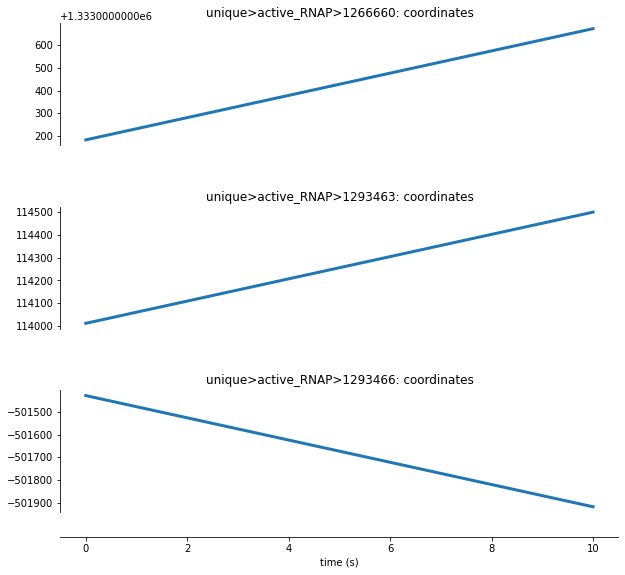

In [23]:
# plot output
te_fig = plot_variables(
    te_data, 
    variables=[
        ('unique', 'active_RNAP', '1266660', 'coordinates'),
        ('unique', 'active_RNAP', '1293463', 'coordinates'),
        ('unique', 'active_RNAP', '1293466', 'coordinates')
        ],
    column_width=10, row_height=3, row_padding=0.5)

Here we can see that the coordinates for these RNA Polymerase molecules are initialized at time=0 but change throughout the simulation. Some polymerase coordinates incease, indicating elongation in one direction, and others decrease, indicating elongation in the opposite direction along the DNA sequence. 

Funadamentally, these changes represent the process of polymerization: as the RNA polymerase molecules travel across the DNA, RNA molecucles are assembled.

## <u>TF Binding<u/>

In [24]:
from ecoli.processes.tf_binding import TfBinding
print(ecoli.processes.tf_binding.__doc__)


Tf Binding

Transcription factor binding sub-model.

This process models how transcription factors bind to promoters on the DNA sequence.



In [25]:
# load in parameters
tfb_params = load_sim_data.get_tf_config()

# initialize process and topology
tf_binding = TfBinding(tfb_params)

tfb_topology = topology_registry.access(tf_binding.name)

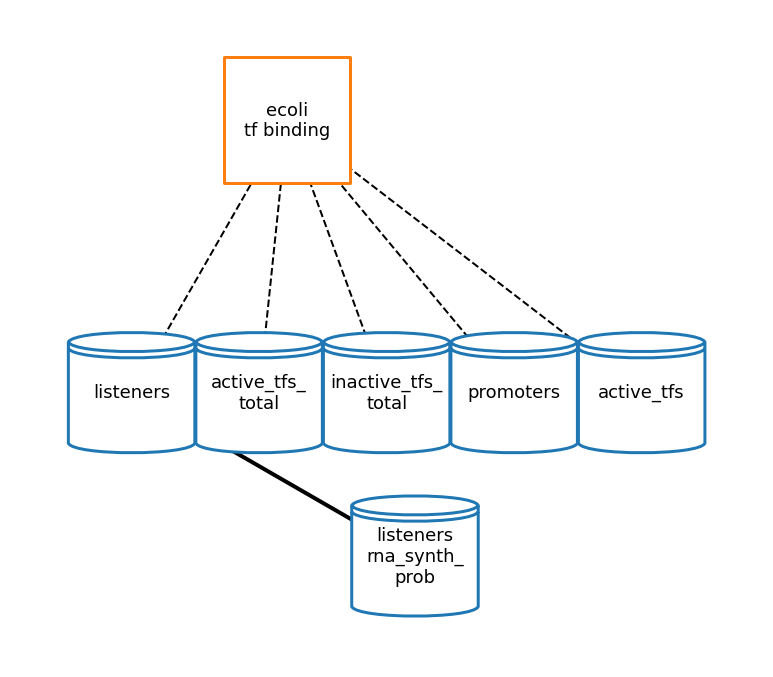

In [26]:
# plot topology
tfb_topology_plot_settings = {
    'node_labels': {
        'ecoli-tf-binding': 'ecoli\ntf binding',
        'listeners\nrna_synth_prob': 'listeners\nrna_synth_\nprob',
        'active_tfs_total': 'active_tfs_\ntotal',
        'inactive_tfs_total': 'inactive_tfs_\ntotal'
    },
    'show_ports': False,
    'node_size': 16000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-tf-binding': (2, 2)}
}

tfb_topology_fig = plot_topology(tf_binding, tfb_topology_plot_settings)

In [27]:
# display ports schema
tfb_ports = tf_binding.ports_schema()
tfb_printout = make_port_printout(tfb_ports)
print(tfb_printout)

promoters:
*:
          TU_index:
                _default: 0
                _updater: set
                _emit: True

          bound_TF:
                _default: 0
                _updater: set
                _emit: True

          submass:
                _default: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
                _emit: True



active_tfs:
     CPLX-125[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     CPLX-172[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     CPLX0-226[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     CPLX0-228[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     CPLX0-7669[c]:
           _default: 0
           _divider: binomial_ecoli
           _em

In [28]:
# run simulation and retrieve final data
tfb_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': tfb_topology}

tfb_data = simulate_process(tf_binding, tfb_settings)


Simulation ID: b831053a-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:29
Completed in 2.40 seconds


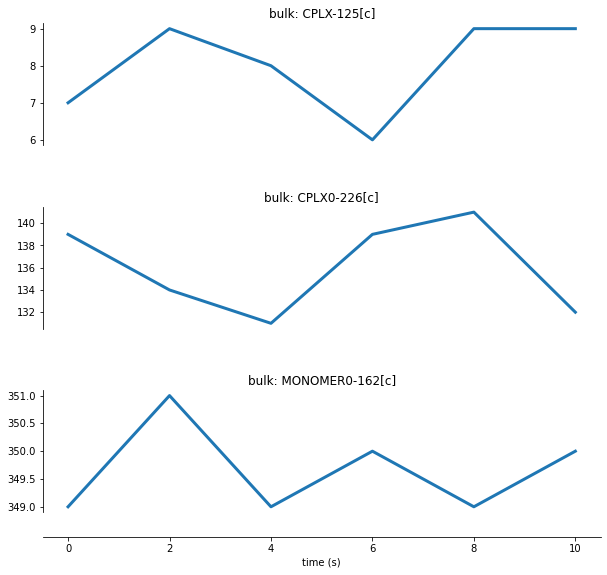

In [29]:
# plot output
tfb_fig_active = plot_variables(
    tfb_data, 
    variables=[
        ('bulk', 'CPLX-125[c]'),
        ('bulk', 'CPLX0-226[c]'),
        ('bulk', 'MONOMER0-162[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

## <u>Chromosome Replication<u/>

In [30]:
from ecoli.processes.chromosome_replication import ChromosomeReplication
print(ecoli.processes.chromosome_replication.__doc__)


Chromosome Replication

Process for chromosome replication. Performs initiation, elongation, and
termination of active partial chromosomes that replicate the chromosome.

First, a round of replication is initiated at a ﬁxed cell mass per origin
of replication and generally occurs once per cell cycle. Second, replication
forks are elongated up to the maximal expected elongation rate, dNTP resource
limitations, and template strand sequence but elongation does not take into
account the action of topoisomerases or the enzymes in the replisome. Finally,
replication forks terminate once they reach the end of their template strand and
the chromosome immediately decatenates forming two separate chromosome molecules.



In [31]:
# load in parameters
cr_params = load_sim_data.get_chromosome_replication_config()

# initialize process and topology
chromosome_replication = ChromosomeReplication(cr_params)

cr_topology = topology_registry.access(chromosome_replication.name)

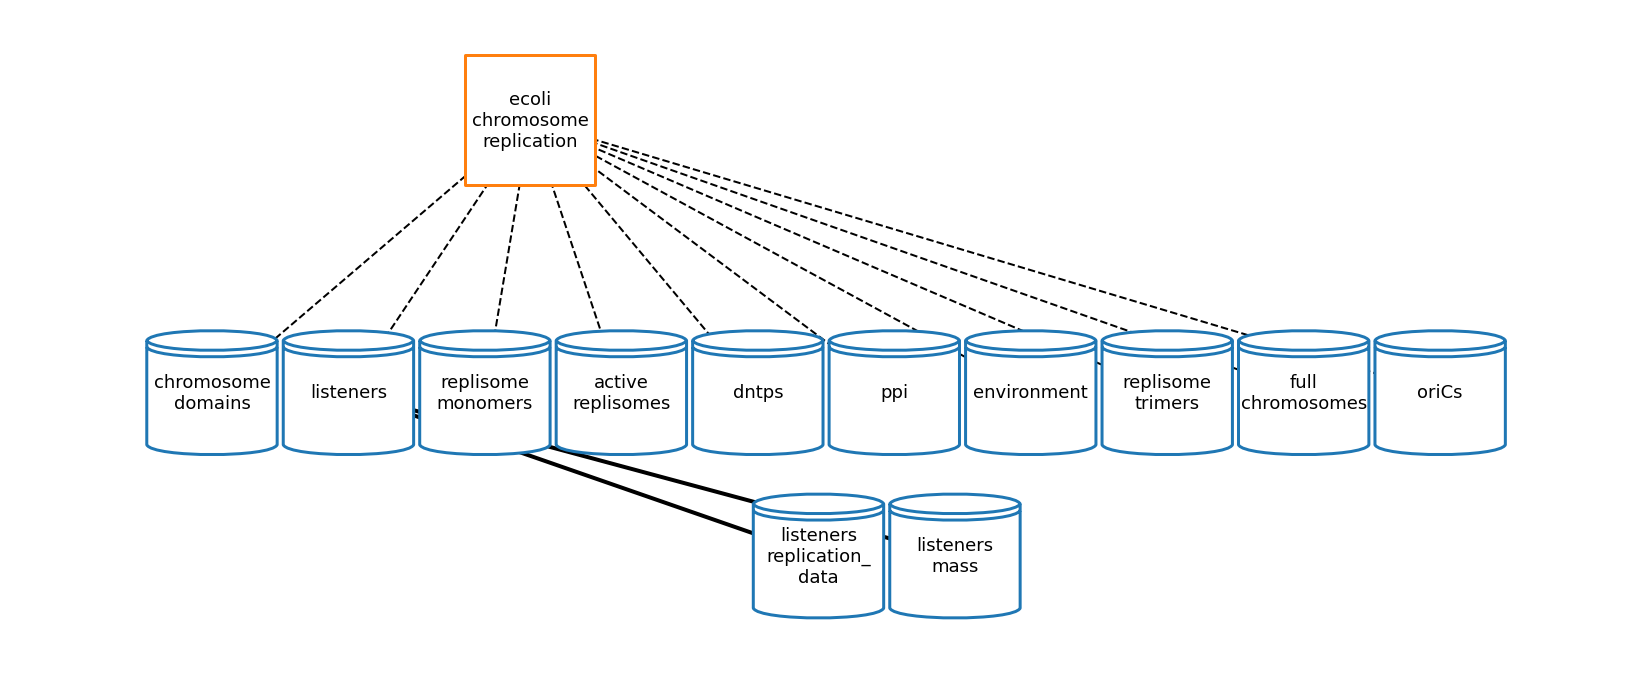

In [32]:
# plot topology
cr_topology_plot_settings = {
    'node_labels': {
        'ecoli-chromosome-replication': 'ecoli\nchromosome\nreplication',
        'replisome_trimers': 'replisome\ntrimers',
        'replisome_monomers': 'replisome\nmonomers',
        'active_replisomes': 'active\nreplisomes',
        'full_chromosomes': 'full\nchromosomes',
        'chromosome_domains': 'chromosome\ndomains',
        'listeners\nreplication_data': 'listeners\nreplication_\ndata'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-chromosome-replication': (3, 2)}
}

cr_topology_fig = plot_topology(chromosome_replication, cr_topology_plot_settings)

In [33]:
# display ports schema
cr_ports = chromosome_replication.ports_schema()
cr_printout = make_port_printout(cr_ports)
print(cr_printout)

replisome_trimers:
     CPLX0-2361[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     CPLX0-3761[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


replisome_monomers:
     CPLX0-3621[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     EG10239-MONOMER[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     EG11500-MONOMER[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     EG11412-MONOMER[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


dntps:
     DATP[c]:
           _default: 0
           _divider: binomial_ecoli
           _

In [34]:
# tweak initial state to trigger replication
cr_initial_state = copy.deepcopy(initial_state)
cr_initial_state['listeners']['mass']['cell_mass'] = 2000.0

# run simulation and retrieve final data
cr_settings = {
    'total_time': 100,
    'initial_state': cr_initial_state,
    'topology': cr_topology,
    'emit_step': 10,
    'return_raw_data': True}

cr_data = simulate_process(chromosome_replication, cr_settings)


Simulation ID: bbf838be-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:35
Completed in 0.409443 seconds


In [35]:
cr_data[0.0]['unique']['oriC']

{'1': {'domain_index': 1}, '2': {'domain_index': 2}}

In [36]:
cr_data[10.0]['unique']['oriC']

{'bc16faba-1588-11ec-9a6e-8c85908ac627': {'domain_index': 19},
 'bc16fbc8-1588-11ec-9a6e-8c85908ac627': {'domain_index': 20}}

Here a new origin of replication (oriC) has formed between time 0 and 10. This indicates the beginning of the chromosome replication process.

## <u>Chromosome Structure<u/>

In [37]:
from ecoli.processes.chromosome_structure import ChromosomeStructure
print(ecoli.processes.chromosome_structure.__doc__)


ChromosomeStructure process

- Resolve collisions between molecules and replication forks on the chromosome.
- Remove and replicate promoters and motifs that are traversed by replisomes.
- Reset the boundaries and linking numbers of chromosomal segments.



In [38]:
# load in parameters
cs_params = load_sim_data.get_chromosome_structure_config()

# initialize process and topology
chromosome_structure = ChromosomeStructure(cs_params)

cs_topology = topology_registry.access(chromosome_structure.name)

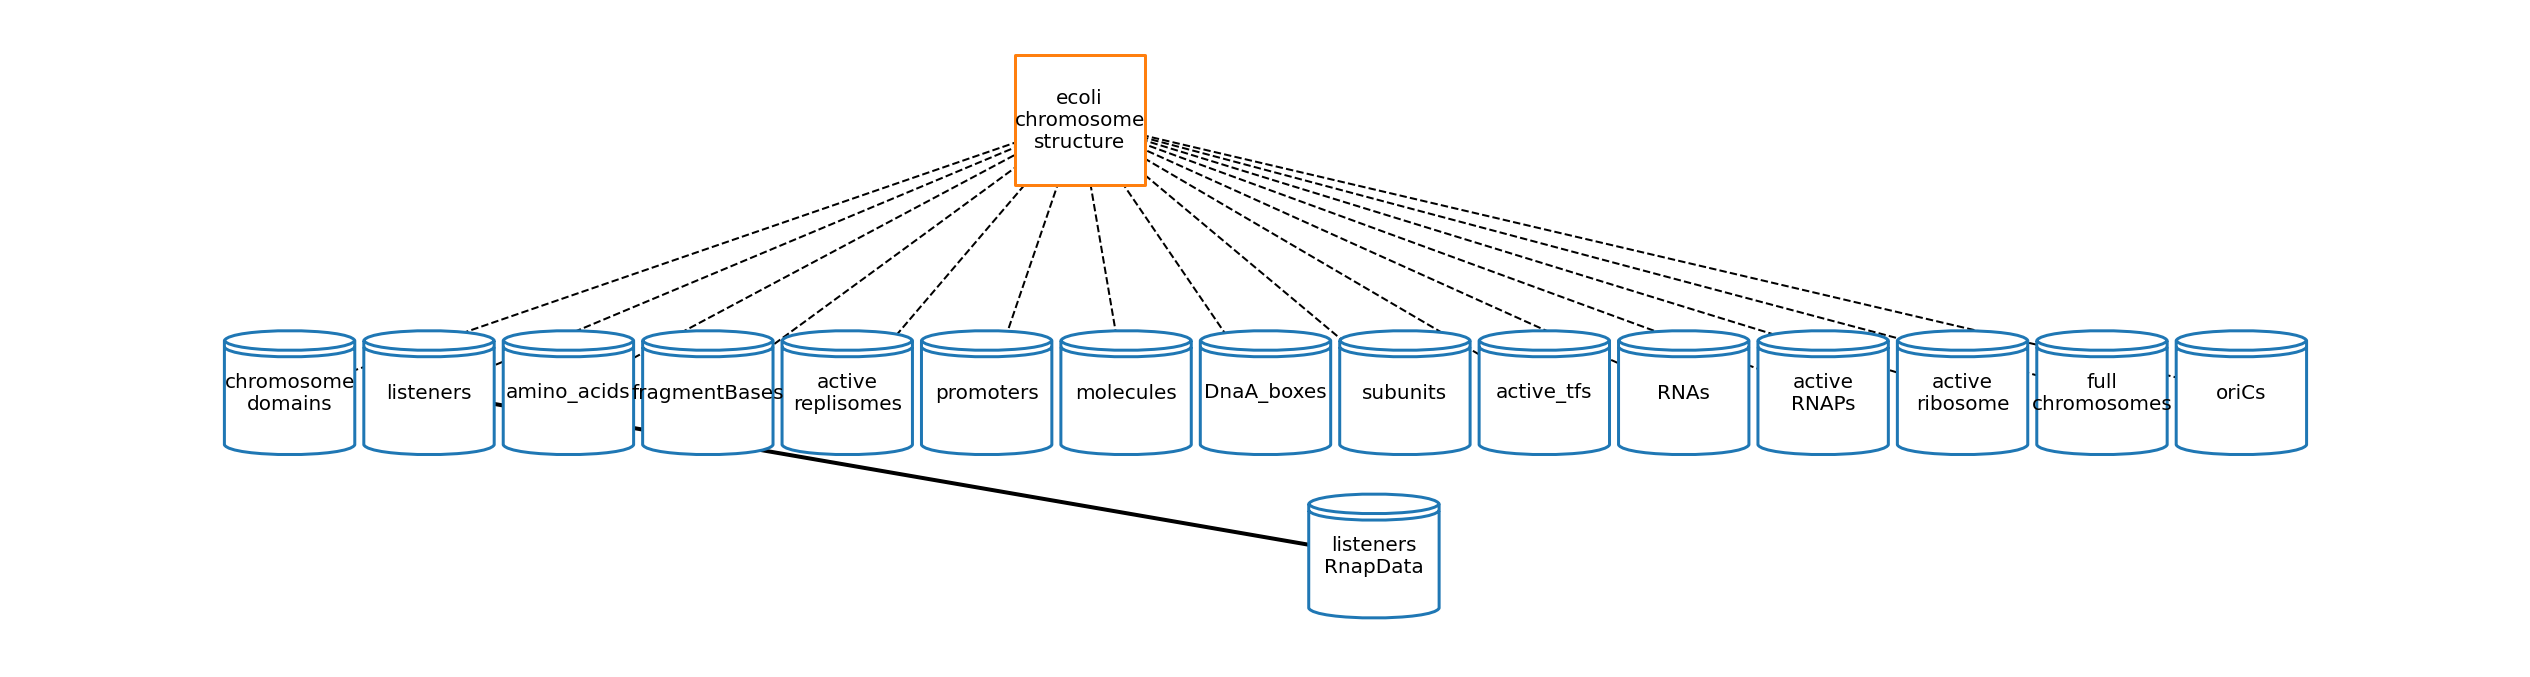

In [39]:
# plot topology
cs_topology_plot_settings = {
    'node_labels': {
        'ecoli-chromosome-structure': 'ecoli\nchromosome\nstructure',
        'full_chromosomes': 'full\nchromosomes',
        'active_ribosome': 'active\nribosome',
        'chromosome_domains': 'chromosome\ndomains',
        'active_replisomes': 'active\nreplisomes',
        'active_RNAPs': 'active\nRNAPs',
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 20,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-chromosome-structure': (6, 2)}
}

cs_topology_fig = plot_topology(chromosome_structure, cs_topology_plot_settings)

In [40]:
# display ports schema
cs_ports = chromosome_structure.ports_schema()
cs_printout = make_port_printout(cs_ports)
print(cs_printout)

listeners:
RnapData:
          n_total_collisions:
                _default: 0
                _updater: set
                _emit: True

          n_headon_collisions:
                _default: 0
                _updater: set
                _emit: True

          n_codirectional_collisions:
                _default: 0
                _updater: set
                _emit: True

          headon_collision_coordinates:
                _default: 0
                _updater: set
                _emit: True

          codirectional_collision_coordinates:
                _default: 0
                _updater: set
                _emit: True


          ... skipping 1 schema entries ...


fragmentBases:
     polymerized_ATP[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     polymerized_CTP[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

  

In [41]:
cs_initial_state = copy.deepcopy(initial_state)

# run simulation and retrieve final data
cs_settings = {
    'total_time': 10,
    'initial_state': cs_initial_state,
    'topology': cs_topology,
    'emit_step': 10,
    'return_raw_data': True}

cs_data = simulate_process(chromosome_structure, cs_settings)


Simulation ID: bce2e26a-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:38
Completed in 2.59 seconds


## <u>Polypeptide Initiation<u/>

In [42]:
from ecoli.processes.polypeptide_initiation import PolypeptideInitiation
print(ecoli.processes.polypeptide_initiation.__doc__)


Polypeptide Initiation

Polypeptide initiation sub-model.

This process models the complementation of 30S and 50S ribosomal subunits
into 70S ribosomes on mRNA transcripts. This process is in many ways
analogous to the TranscriptInitiation process - the number of initiation
events per transcript is determined in a probabilistic manner and dependent
on the number of free ribosomal subunits, each mRNA transcript’s translation
efficiency, and the counts of each type of transcript.



In [43]:
# load in parameters
pi_params = load_sim_data.get_polypeptide_initiation_config()

# initialize process and topology
polypeptide_initiation = PolypeptideInitiation(pi_params)

pi_topology = topology_registry.access(polypeptide_initiation.name)

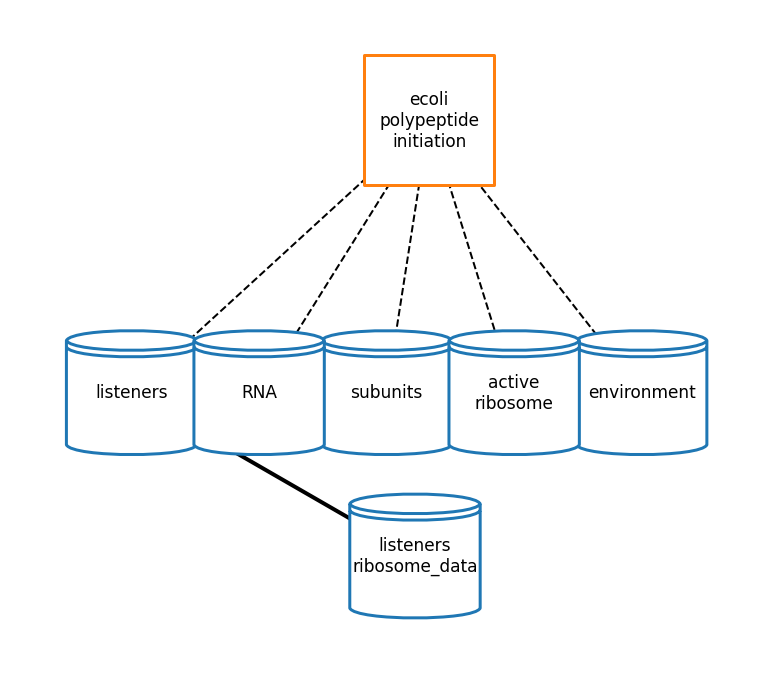

In [44]:
# plot topology
pi_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-initiation': 'ecoli\npolypeptide\ninitiation',
        'active_ribosome': 'active\nribosome'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-initiation': (3, 2)}
}

pi_topology_fig = plot_topology(polypeptide_initiation, pi_topology_plot_settings)

In [45]:
# display ports schema
pi_ports = polypeptide_initiation.ports_schema()
pi_printout = make_port_printout(pi_ports)
print(pi_printout)

environment:
     media_id:
           _default: 
           _updater: set


listeners:
ribosome_data:
          ribosomes_initialized:
                _default: 0
                _updater: set
                _emit: True

          prob_translation_per_transcript:
                _default: []
                _updater: set
                _emit: True

          effective_elongation_rate:
                _default: 0.0
                _updater: set
                _emit: True



active_ribosome:
*:
          unique_index:
                _default: 0

          protein_index:
                _default: 0

          peptide_length:
                _default: 0
                _emit: True

          mRNA_index:
                _default: 0

          pos_on_mRNA:
                _default: 0
                _emit: True



RNA:
*:
          TU_index:
                _default: 0

          can_translate:
                _default: False

          unique_index:
                _default: 0



subun

In [46]:
# run simulation and retrieve final data
pi_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': pi_topology}

pi_data = simulate_process(polypeptide_initiation, pi_settings)


Simulation ID: bfa7f6ca-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:42
Completed in 2.20 seconds


We can observe the 30S ribosomal subunit ('CPLX0-3953[c]') and 50S ribosomal subunit (CPLX0-3962[c]) molecule counts:

/var/folders/t4/q28s90qs5r755xvnzjg6vkc40000gn/T/ipykernel_74279/3946241941.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pi_fig.show()


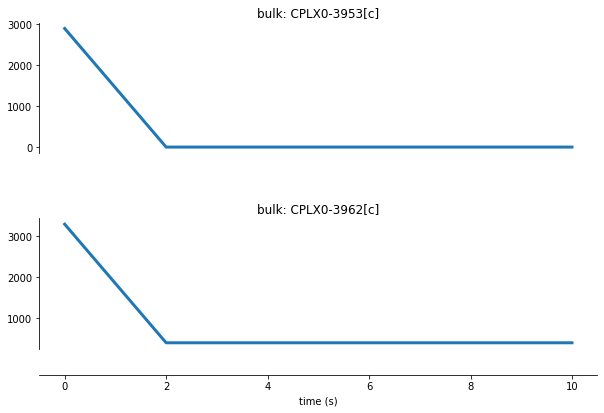

In [47]:
# plot output
pi_fig = plot_variables(
    pi_data, 
    variables=[
        ('bulk', 'CPLX0-3953[c]'),
        ('bulk', 'CPLX0-3962[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

pi_fig.savefig('notebooks/pi_fig.png')
pi_fig.show()

The decrease within the first time step of the simulation demonstrates how active 70S ribosomes are rapidly formed from free 30S and 50S subunits. We can also see how the 30S ribosome subunit (CPLX0-3953[c]) is limiting.

## <u>Polypeptide Elongation<u/>

In [48]:
from ecoli.processes.polypeptide_elongation import PolypeptideElongation
print(ecoli.processes.polypeptide_elongation.__doc__)


Polypeptide Elongation

Polypeptide elongation sub-model.

This process models the polymerization of amino acids into polypeptides
by ribosomes using an mRNA transcript as a template. Elongation terminates
once a ribosome has reached the end of an mRNA transcript. Polymerization
occurs across all ribosomes simultaneously and resources are allocated to
maximize the progress of all ribosomes within the limits of the maximum ribosome
elongation rate, available amino acids and GTP, and the length of the transcript.



In [49]:
# load in parameters
pe_params = load_sim_data.get_polypeptide_elongation_config()

# initialize process and topology
polypeptide_elongation = PolypeptideElongation(pe_params)

pe_topology = topology_registry.access(polypeptide_elongation.name)

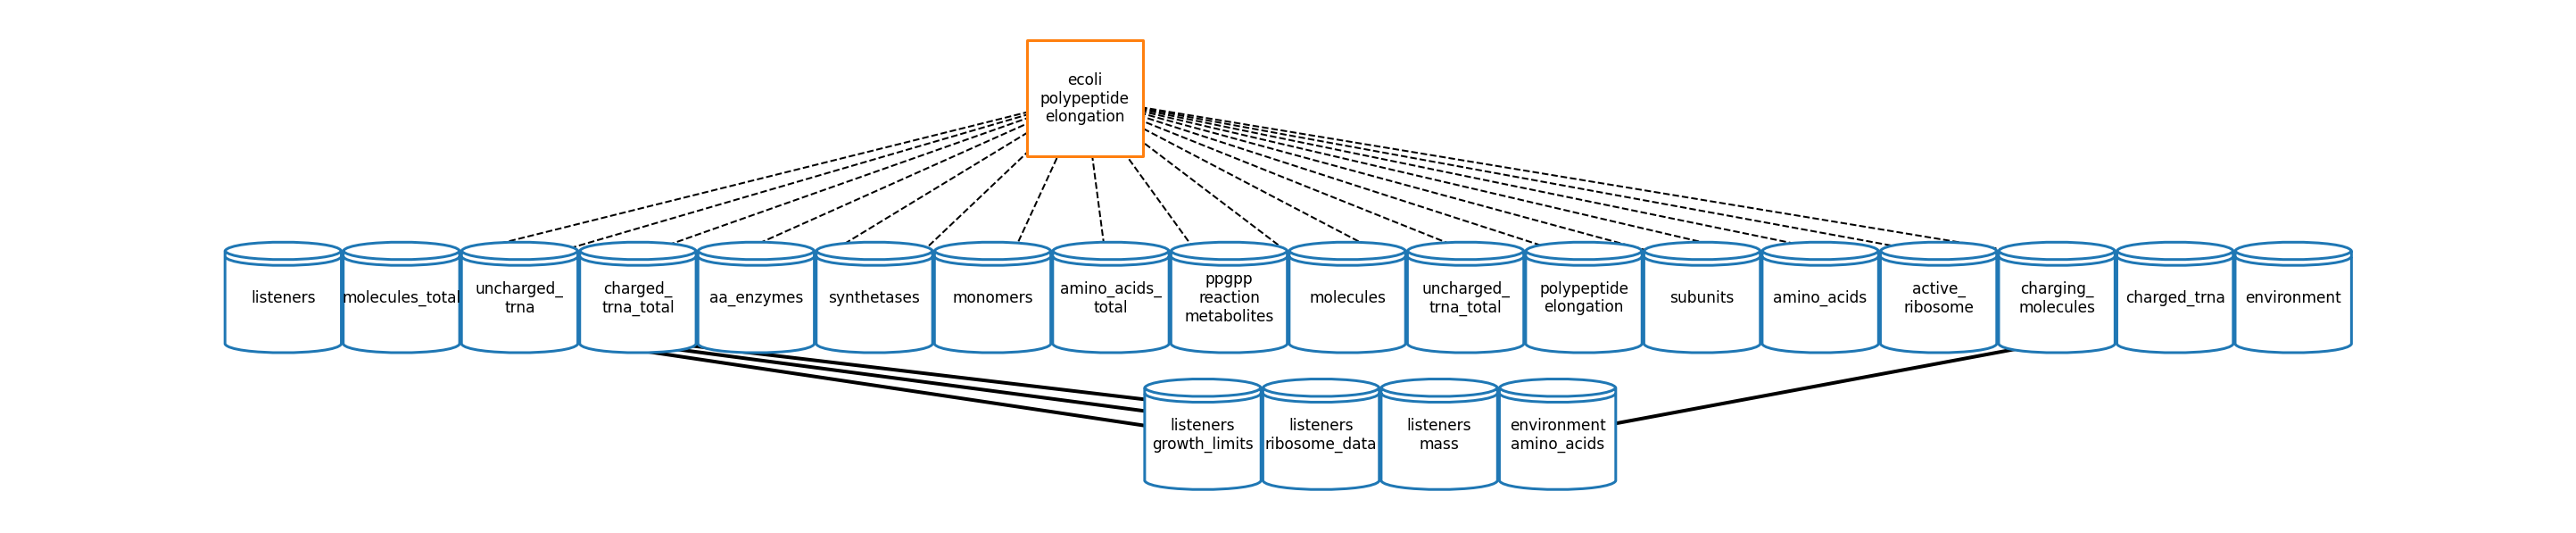

In [50]:
# plot topology
pe_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-elongation': 'ecoli\npolypeptide\nelongation',
        'uncharged_trna': 'uncharged_\ntrna',
        'uncharged_trna_total': 'uncharged_\ntrna_total',
        'charged_trna_total': 'charged_\ntrna_total',
        'charging_molecules': 'charging_\nmolecules',
        'active_ribosome': 'active_\nribosome',
        'polypeptide_elongation': 'polypeptide\nelongation',
        'ppgpp_reaction_metabolites': 'ppgpp\nreaction\nmetabolites',
        'chromosome_domains': 'chromosome\ndomains',
        'listeners\nreplication_data': 'listeners\nreplication_\ndata',
        'amino_acids_total': 'amino_acids_\ntotal'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-elongation': (7, 1.75)}
}

pe_topology_fig = plot_topology(polypeptide_elongation, pe_topology_plot_settings)

In [51]:
# display ports schema
pe_ports = polypeptide_elongation.ports_schema()
pe_printout = make_port_printout(pe_ports)
print(pe_printout)

environment:
     media_id:
           _default: 
           _updater: set

amino_acids:
          L-ALPHA-ALANINE:
                _default: 0
                _divider: binomial_ecoli
                _emit: True
                _properties: {'bulk': True}

          ARG:
                _default: 0
                _divider: binomial_ecoli
                _emit: True
                _properties: {'bulk': True}

          ASN:
                _default: 0
                _divider: binomial_ecoli
                _emit: True
                _properties: {'bulk': True}

          L-ASPARTATE:
                _default: 0
                _divider: binomial_ecoli
                _emit: True
                _properties: {'bulk': True}

          CYS:
                _default: 0
                _divider: binomial_ecoli
                _emit: True
                _properties: {'bulk': True}


          ... skipping 16 schema entries ...


listeners:
mass:
          cell_mass:
                _def

In [52]:
# run simulation and retrieve final data
pe_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': pe_topology}

pe_data = simulate_process(polypeptide_elongation, pe_settings)


Simulation ID: c2c7bebc-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:48
Completed in 3.63 seconds


We can see from the cell above that each active ribosome molecule is represented by an ID number. Let's analyze the polypeptide length and the ribosome's position on mRNA of one active ribosome within this process:

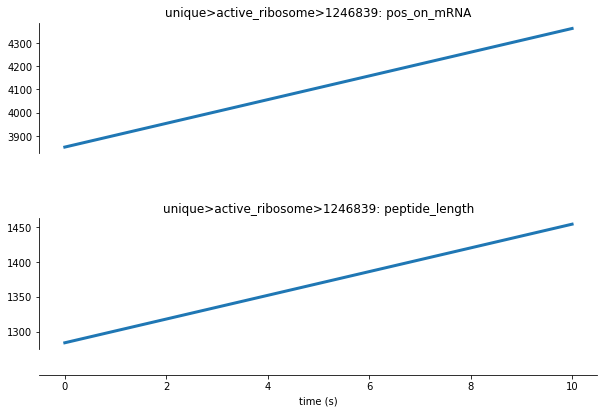

In [53]:
# plot output
RIBOSOME_ID = '1246839'

pe_fig = plot_variables(
    pe_data, 
    variables=[
        ('unique', 'active_ribosome', RIBOSOME_ID, 'pos_on_mRNA'),
        ('unique', 'active_ribosome', RIBOSOME_ID, 'peptide_length')
        ],
    column_width=10, row_height=3, row_padding=0.5)

Here we can see that as the simulation progresses, the ribosome travels along the mRNA strand (as shown by the increasing pos_on_mRNA variable) and polymerization of amino acids into a polypeptide occurs (as shown by the increasing peptide_length variable).

After elongation terminates, we can see an increase in protein counts:

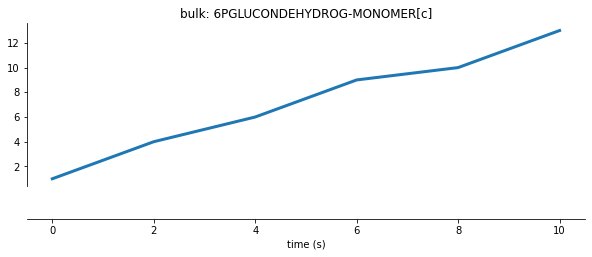

In [54]:
pe_fig1 = plot_variables(
    pe_data, 
    variables=[
        ('bulk', '6PGLUCONDEHYDROG-MONOMER[c]')
    ],
    column_width=10, row_height=3, row_padding=0.5)

## <u>Protein Degradation<u/>

In [55]:
from ecoli.processes.protein_degradation import ProteinDegradation
print(ecoli.processes.protein_degradation.__doc__)


Protein Degradation

Protein degradation sub-model.

This process accounts for the degradation of protein monomers.
Specific proteins to be degraded are selected as a Poisson process.



In [56]:
# load in parameters
pd_params = load_sim_data.get_protein_degradation_config()

# initialize process and topology
protein_degradation = ProteinDegradation(pd_params)

pd_topology = topology_registry.access(protein_degradation.name)

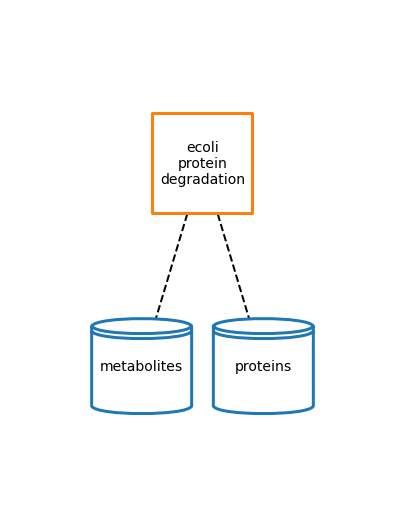

In [57]:
# plot topology
pd_topology_plot_settings = {
    'buffer': 1,
    'node_labels': {
        'ecoli-protein-degradation': 'ecoli\nprotein\ndegradation'
    },
    'node_distance': 5,
    'show_ports': False,
    'node_size': 10000,
    'dashed_edges': True,
    'coordinates': {'ecoli-protein-degradation': (1.5, 0.5)}
}

pd_topology_fig = plot_topology(protein_degradation, pd_topology_plot_settings)

In [58]:
# display ports schema
pd_ports = protein_degradation.ports_schema()
pd_printout = make_port_printout(pd_ports)
print(pd_printout)

metabolites:
     L-ALPHA-ALANINE[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     ARG[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     ASN[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     L-ASPARTATE[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     CYS[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


     ... skipping 17 schema entries ...

proteins:
     1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER[i]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     1-PFK-MONOMER[c]:
           _default: 0
           _divider: bi

In [59]:
# run simulation and retrieve final data
pd_settings = {
    'total_time': 600,
    'initial_state': initial_state,
    'topology': pd_topology,
    'emit_step': 10}

pd_data = simulate_process(protein_degradation, pd_settings)


Simulation ID: c6dc4fd6-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:22:53
Completed in 7.63 seconds


For protein degradation, let's look at the ARTJ-MONOMER[p] monomer, a protein selected for degradation at this time point, as it degrades into its subcomponents:

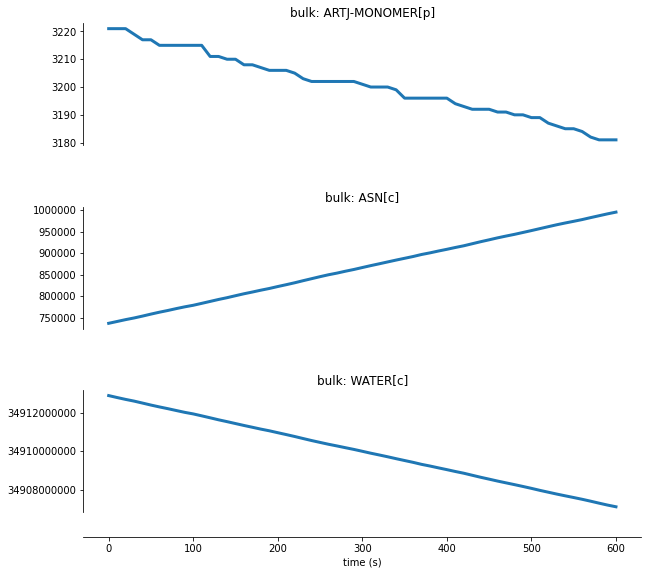

In [60]:
# plot output
pd_fig = plot_variables(
    pd_data, 
    variables=[
        ('bulk', 'ARTJ-MONOMER[p]'),
        ('bulk', 'ASN[c]'),
        ('bulk', 'WATER[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

We can see here that as the ARTJ-MONOMER[p] protein degrades, the count for the amino acid asparagine increases and water is consumed.

## <u>RNA Degradation<u/>

In [61]:
from ecoli.processes.rna_degradation import RnaDegradation
print(ecoli.processes.rna_degradation.__doc__)


RNA Degradation

Submodel for RNA degradation.

Mathematical formulation:

dr/dt = Kb - Kd * r
or,

dr/dt = Kb - kcatEndoRNase * EndoRNase * r / (Km + r)
or,

dr/dt = Kb - kcatEndoRNase * EndoRNase * r/Km / (1 + Sum(r/Km))

    where   r = RNA counts
            Kb = RNA production given a RNAP synthesis rate 
            tau = doubling time
            kcatEndoRNase = enzymatic activity for EndoRNases
            kd = RNA degradation rates 
            Km = Michaelis-Menten constants fitted to recapitulate first-order
            RNA decay:
                kd * r = kcatEndoRNase * EndoRNase * r / (Km + r),
                    non-cooperative EndoRNases
                kd * r = kcatEndoRNase * EndoRNase * r/Km / (1 + sum(r/Km)),
                    cooperation

This sub-model encodes molecular simulation of RNA degradation as two main
steps guided by RNases, "endonucleolytic cleavage" and "exonucleolytic
digestion":

1. Compute total counts of RNA to be degraded (D) and total capacity

In [62]:
# load in parameters
rd_params = load_sim_data.get_rna_degradation_config()

# initialize process and topology
rna_degradation = RnaDegradation(rd_params)

rd_topology = topology_registry.access(rna_degradation.name)

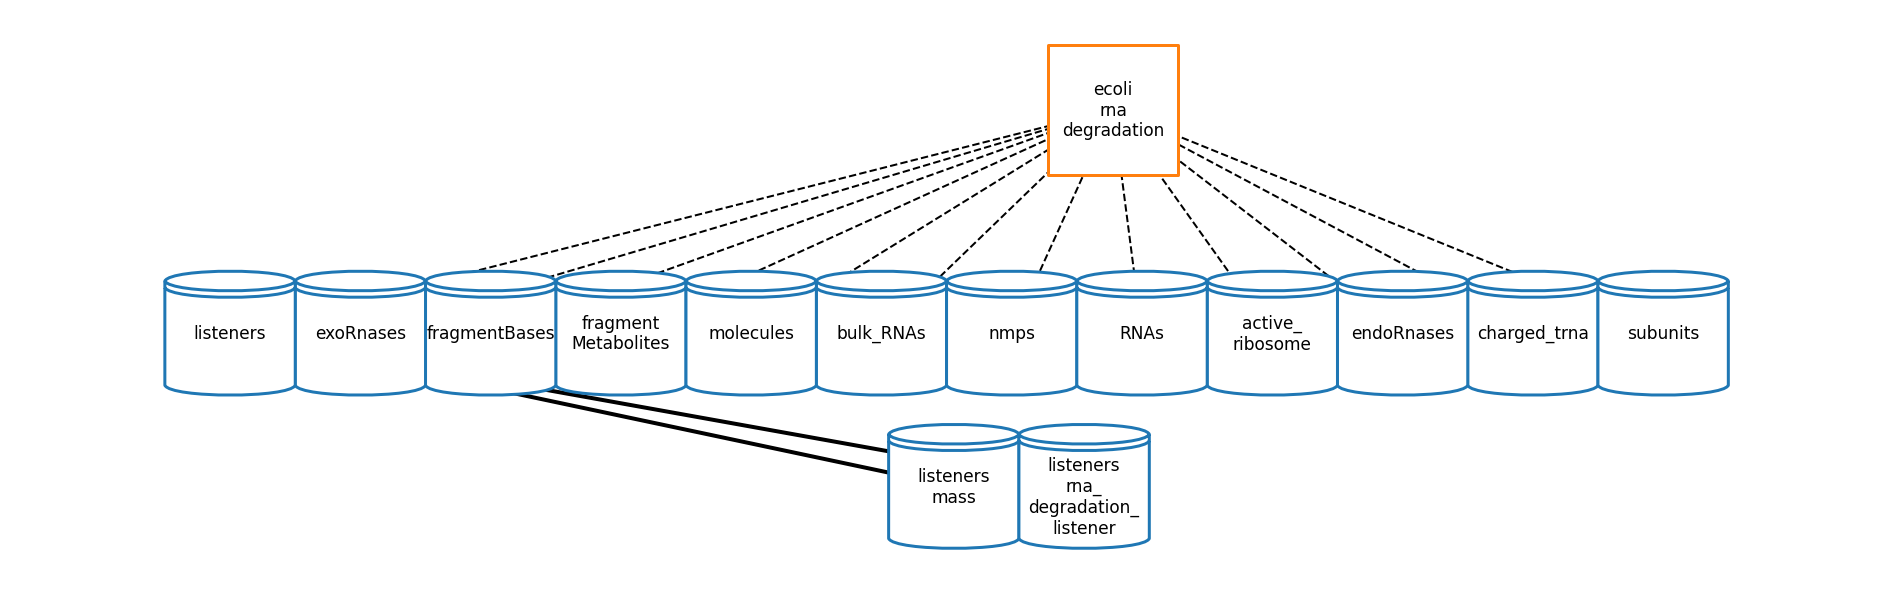

In [63]:
# plot topology
rd_topology_plot_settings = {
    'node_labels': {
        'ecoli-rna-degradation': 'ecoli\nrna\ndegradation',
        'fragmentMetabolites': 'fragment\nMetabolites',
        'listeners\nrna_degradation_listener': '\nlisteners\nrna_\ndegradation_\nlistener',
        'active_ribosome': 'active_\nribosome'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-rna-degradation': (7, 1.75)}
}

rd_topology_fig = plot_topology(rna_degradation, rd_topology_plot_settings)

In [64]:
# display ports schema
rd_ports = rna_degradation.ports_schema()
rd_printout = make_port_printout(rd_ports)
print(rd_printout)

charged_trna:
     charged-alaT-tRNA[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     charged-alaU-tRNA[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     charged-alaV-tRNA[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     charged-alaW-tRNA[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     charged-alaX-tRNA[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


     ... skipping 81 schema entries ...

bulk_RNAs:
     EG10001_RNA[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}
           _updater: nonnegative_accumulate

 

In [65]:
# run simulation and retrieve final data
rd_settings = {
    'total_time': 100,
    'initial_state': initial_state,
    'topology': rd_topology}

rd_data = simulate_process(rna_degradation, rd_settings)


Simulation ID: cc0ed92e-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:23:03
Completed in 11.87 seconds


For RNA degradation, let's look at a few RNA molecules as the simulation runs:

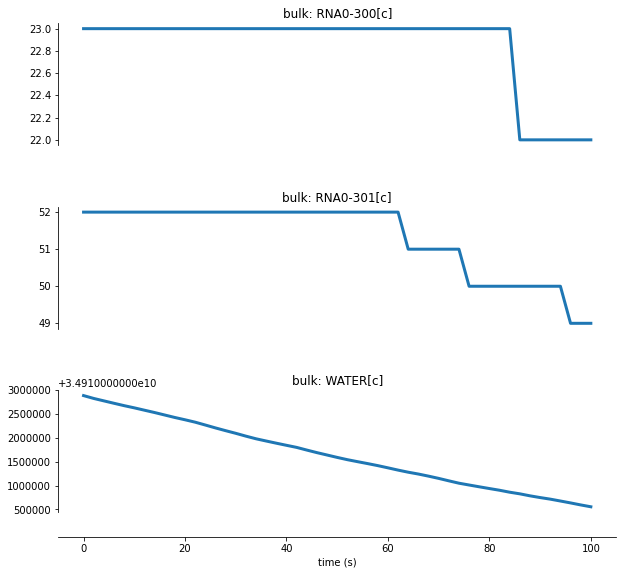

In [66]:
# plot output
rd_fig = plot_variables(
    rd_data, 
    variables=[
        ('bulk', 'RNA0-300[c]'),
        ('bulk', 'RNA0-301[c]'),
        ('bulk', 'WATER[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

RNAs are selected and degraded by endoRNases, and non-functional RNA fragments are digested through exoRNases. During the process water is consumed, and nucleotides, pyrophosphate and protons are released.

## <u>Two Component System<u/>

In [67]:
from ecoli.processes.two_component_system import TwoComponentSystem
print(ecoli.processes.two_component_system.__doc__)


Two Component System

Two component system sub-model.

This process models the phosphotransfer reactions of signal transduction pathways.

Specifically, phosphate groups are transferred from histidine kinases to response regulators
and back in response to counts of ligand stimulants.



In [68]:
# load in parameters
tcs_params = load_sim_data.get_two_component_system_config()
    
# initialize process and topology
two_component_system = TwoComponentSystem(tcs_params)

tcs_topology = topology_registry.access(two_component_system.name)

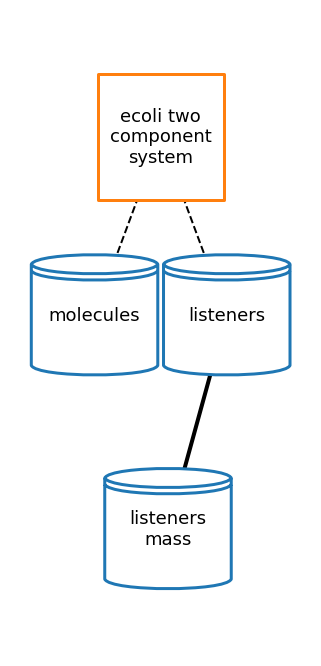

In [69]:
# plot topology
tcs_topology_plot_settings = {
    'node_labels': {
        'ecoli-two-component-system': 'ecoli two\ncomponent\nsystem'
    },
    'show_ports': False,
    'node_size': 16000,
    'node_distance': 5.0,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-two-component-system': (1.35, 1)}
}

tcs_topology_fig = plot_topology(two_component_system, tcs_topology_plot_settings)

In [70]:
# display ports schema
tcs_ports = two_component_system.ports_schema()
tcs_printout = make_port_printout(tcs_ports)
print(tcs_printout)

molecules:
     PHOSPHO-ARCB-CPLX[i]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     ADP[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     PROTON[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     ARCB-CPLX[i]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     ATP[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


     ... skipping 36 schema entries ...

listeners:
mass:
          cell_mass:
                _default: 0






In [71]:
# tweak initial state??
tcs_initial_state = copy.deepcopy(initial_state)

# run simulation and retrieve final data
tcs_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': tcs_topology}

tcs_data = simulate_process(two_component_system, tcs_settings)


Simulation ID: d5886a10-1588-11ec-9a6e-8c85908ac627
Created: 09/14/2021 at 11:23:18
Completed in 0.051169 seconds


In [90]:
tcs_data

{'bulk': {'PHOSPHO-ARCB-CPLX[i]': [0, 0, 0, 0, 0, 0],
  'ADP[c]': [404873, 404873, 404873, 404873, 404873, 404873],
  'PROTON[c]': [52, 52, 52, 52, 52, 52],
  'ARCB-CPLX[i]': [0, 0, 0, 0, 0, 0],
  'ATP[c]': [7866030, 7866030, 7866030, 7866030, 7866030, 7866030],
  'PHOSPHO-ARCA[c]': [0, 0, 0, 0, 0, 0],
  'ARCA-MONOMER[c]': [2769, 2769, 2769, 2769, 2769, 2769],
  'Pi[c]': [408412, 408412, 408412, 408412, 408412, 408412],
  'WATER[c]': [34912886892,
   34912886892,
   34912886892,
   34912886892,
   34912886892,
   34912886892],
  'PHOSPHO-BAES-INDOLE-CPLX[i]': [0, 0, 0, 0, 0, 0],
  'BAES-INDOLE-CPLX[i]': [0, 0, 0, 0, 0, 0],
  'PHOSPHO-BAER[c]': [0, 0, 0, 0, 0, 0],
  'BAER-MONOMER[c]': [200, 200, 200, 200, 200, 200],
  'PHOSPHO-BAES[i]': [0, 0, 0, 0, 0, 0],
  'BAES-MONOMER[i]': [19, 19, 19, 19, 19, 19],
  'PHOSPHO-BASS-FE+3-CPLX[i]': [0, 0, 0, 0, 0, 0],
  'BASS-FE+3-CPLX[i]': [0, 0, 0, 0, 0, 0],
  'PHOSPHO-BASR[c]': [0, 0, 0, 0, 0, 0],
  'BASR-MONOMER[c]': [180, 180, 180, 180, 180, 180],

Phosphate groups are transferred from histidine kinases to response regulators and back in response to counts of ligand stimulants

In [91]:
# # plot output
# tcs_fig = plot_variables(
#     tcs_data, 
#     variables=[
#         ],
#     column_width=10, row_height=3, row_padding=0.5)

## <u>Equilibrium<u/>

In [ ]:
from ecoli.processes.equilibrium import Equilibrium
print(ecoli.processes.equilibrium.__doc__)

In [ ]:
# load in parameters
eq_params = load_sim_data.get_equilibrium_config()

# initialize process and topology
equilibrium = Equilibrium(eq_params)

eq_topology = topology_registry.access(equilibrium.name)

In [ ]:
# plot topology
eq_topology_plot_settings = {
    'node_labels': {
        'ecoli-equilibrium': 'ecoli\nequilibrium',
        'listeners\nequilibrium_listener': '\nlisteners\nequilibrium\nlistener'
    },
    'show_ports': False,
    'node_size': 14000,
    'node_distance': 5.0,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-equilibrium': (1.5, 1.25)}
}

eq_topology_fig = plot_topology(equilibrium, eq_topology_plot_settings)

In [ ]:
# display ports schema
eq_ports = equilibrium.ports_schema()
eq_printout = make_port_printout(eq_ports)
print(eq_printout)

In [ ]:
# run simulation and retrieve final data
eq_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': eq_topology}

eq_data = simulate_process(equilibrium, eq_settings)

In [ ]:
# # plot output
# eq_fig = plot_variables(
#     eq_data, 
#     variables=[
#         ],
#     column_width=10, row_height=3, row_padding=0.5)

## <u>Metabolism<u/>

In [5]:
from ecoli.processes.metabolism import Metabolism
print(ecoli.processes.metabolism.__doc__)


Metabolism

Metabolism sub-model. Encodes molecular simulation of microbial metabolism using flux-balance analysis.

This process demonstrates how metabolites are taken up from the environment
and converted into other metabolites for use in other processes.



In [6]:
load_sim_data.sim_data.process.metabolism

In [7]:
load_sim_data.sim_data.process.metabolism.linked_metabolites

{'S-ADENOSYLMETHIONINE[c]': {'lead': 'MET[c]', 'ratio': 0.5434782608695652}}

In [10]:
# load in parameters
meta_params = load_sim_data.get_metabolism_config()

# from vivarium.core.engine import pf
# print(pf(meta_params))

# initialize process and topology
metabolism = Metabolism(meta_params)

# meta_topology = topology_registry.access(metabolism.name)

METABOLISM: <reconstruction.ecoli.dataclasses.process.metabolism.Metabolism object at 0x12f1223d0>


AttributeError: 'ConcentrationUpdates' object has no attribute 'linked_metabolites'

In [ ]:
# plot topology
meta_topology_plot_settings = {
    'node_labels': {
        'ecoli-metabolism': 'ecoli\nmetabolism',
        'kinetics_enzymes': 'kinetics\nenzymes',
        'kinetics_substrates': 'kinetics\nsubstrates',
        'environment\nexchange_data': '\nenvironment\nexchange_\ndata',
        'listeners\nenzyme_kinetics': '\nlisteners\nenzyme_\nkinetics',
        'polypeptide_elongation': 'polypeptide_\nelongation'
    },
    'show_ports': False,
    'node_size': 15000,
    'node_distance': 3.2,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-metabolism': (4.5, 2)}
}

meta_topology_fig = plot_topology(metabolism, meta_topology_plot_settings)

In [ ]:
# display ports schema
meta_ports = metabolism.ports_schema()
meta_printout = make_port_printout(meta_ports)
print(meta_printout)

In [ ]:
# run simulation and retrieve final data
meta_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': meta_topology}

meta_data = simulate_process(metabolism, meta_settings)

In [ ]:
reaction_fluxes = meta_data['listeners']['fba_results']['reactionFluxes']
del reaction_fluxes[0]

In [ ]:
# generate time series
reaction_fluxes_time_series = {}

for fluxes in reaction_fluxes:
    for reaction_id, flux in enumerate(fluxes):
        if reaction_id not in reaction_fluxes_time_series:
            reaction_fluxes_time_series[reaction_id] = []
        reaction_fluxes_time_series[reaction_id].append(flux)

In [ ]:
# plot figure
import matplotlib.pyplot as plt

fig = plt.figure()

for reaction_id, time_series in reaction_fluxes_time_series.items():
    plt.plot(time_series)
    
plt.title('Reaction Fluxes')

# **3. Combining Processes into Composite**

We will now demonstrate how the following combinations of processes function within the model:

1. Transcript initiation + transcript elongation
2. Polypeptide initiation + polypeptide elongation
3. Polypeptide initiation + polypeptide elongation + complexation

For this section, we need to load in the composer:
 * A `Composer` is a class that generates `Composite` models, with many processes wired together through shared `Stores`.
 * `Ecoli` is the current master composite of the E. coli model.

In [ ]:
from vivarium.core.composer import Composite

## <u>Transcript Initiation + Transcript Elongation<u/>

Description:

In [ ]:
# TRANSCRIPT INITATION

# load in parameters
ti_params = load_sim_data.get_transcript_initiation_config()

# initialize process and topology
transcript_initiation = TranscriptInitiation(ti_params)

ti_topology = topology_registry.access(transcript_initiation.name)

In [ ]:
# TRANSCRIPT ELONGATION

# load in parameters
te_params = load_sim_data.get_transcript_elongation_config()

# initialize process and topology
transcript_elongation = TranscriptElongation(te_params)

te_topology = topology_registry.access(transcript_elongation.name)

In [ ]:
# generate composite model
tite_composite = Composite({
    'processes': {
        transcript_initiation.name: transcript_initiation,
        transcript_elongation.name: transcript_elongation
    },
    'topology': {
        transcript_initiation.name: ti_topology,
        transcript_elongation.name: te_topology
    }
})

In [ ]:
# plot topology
tite_topology_plot_settings = {
    'node_labels': {
        'ecoli-transcript-initiation': 'ecoli\ntranscript\ninitiation',
        'ecoli-transcript-elongation': 'ecoli\ntranscript\nelongation',
        'unique\nfull_chromosome': 'unique\nfull_\nchromosome',
        'listeners\nrna_synth_prob': 'listeners\nrna_synth_\nprob',
        'listeners\nribosome_data': 'listeners\nribosome_\ndata',
        'listeners\ntranscript_elongation_listener': '\nlisteners\ntranscript_\nelongation_\nlistener'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-transcript-initiation': (4, 2),
                    'ecoli-transcript-elongation': (6, 2)}
}

tite_topology_fig = plot_topology(tite_composite, tite_topology_plot_settings)

In [ ]:
# run simulation and retrieve final data
tite_settings = {
    'total_time': 10,
    'initial_state': initial_state
    }

tite_data = simulate_composite(tite_composite, tite_settings)

In [ ]:
# RNA Polymerase binds to and moves along the chromosome
# Depends on ID of RNA Polymerase, which changes with each simulation

pp(tite_data['unique']['active_RNAP'])

## <u>Polypeptide Initiation + Polypeptide Elongation<u/>

Description:

In [ ]:
# POLYPEPTIDE INITIATION

# load in parameters
pi_params = load_sim_data.get_polypeptide_initiation_config()

# initialize process and topology
polypeptide_initiation = PolypeptideInitiation(pi_params)

pi_topology = topology_registry.access(polypeptide_initiation.name)

In [ ]:
# POLYPEPTIDE ELONGATION

# load in parameters
pe_params = load_sim_data.get_polypeptide_elongation_config()

# initialize process and topology
polypeptide_elongation = PolypeptideElongation(pe_params)

pe_topology = topology_registry.access(polypeptide_elongation.name)

In [ ]:
# generate composite model
pipe_composite = Composite({
    'processes': {
        polypeptide_initiation.name: polypeptide_initiation,
        polypeptide_elongation.name: polypeptide_elongation
    },
    'topology': {
        polypeptide_initiation.name: pi_topology,
        polypeptide_elongation.name: pe_topology
    }
})

In [ ]:
# plot topology
pipe_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-initiation': 'ecoli\npolypeptide\ninitiation',
        'ecoli-polypeptide-elongation': 'ecoli\npolypeptide\nelongation',
        'unique\nactive_ribosome': 'unique\nactive_\nribosome',
        'process_state\npolypeptide_elongation': 'process_state\npolypeptide_\nelongation'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.8,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-initiation': (3, 2),
                    'ecoli-polypeptide-elongation': (5, 2)}
}

pipe_topology_fig = plot_topology(pipe_composite, pipe_topology_plot_settings)

In [ ]:
# run simulation and retrieve final data
pipe_settings = {
    'total_time': 10,
    'initial_state': initial_state
    }

pipe_data = simulate_composite(pipe_composite, pipe_settings)

## <u>Polypeptide Initiation + Polypeptide Elongation + Complexation<u/>

Description:

In [ ]:
from vivarium.core.composer import Composite
from ecoli.processes.polypeptide_initiation import PolypeptideInitiation
from ecoli.processes.polypeptide_elongation import PolypeptideElongation
from ecoli.processes.complexation import Complexation

In [ ]:
# POLYPEPTIDE INITIATION

# load in parameters
pi_params = load_sim_data.get_polypeptide_initiation_config()

# initialize process and topology
polypeptide_initiation = PolypeptideInitiation(pi_params)

pi_topology = topology_registry.access(polypeptide_initiation.name)

In [ ]:
# POLYPEPTIDE ELONGATION

# load in parameters
pe_params = load_sim_data.get_polypeptide_elongation_config()

# initialize process and topology
polypeptide_elongation = PolypeptideElongation(pe_params)

pe_topology = topology_registry.access(polypeptide_elongation.name)

In [ ]:
# COMPLEXATION

# load in parameters
cplx_config = load_sim_data.get_complexation_config()

# initialize process and topology
complexation = Complexation(cplx_config)

cplx_topology = topology_registry.access(complexation.name)

In [ ]:
# generate composite model
pipec_composite = Composite({
    'processes': {
        polypeptide_initiation.name: polypeptide_initiation,
        polypeptide_elongation.name: polypeptide_elongation,
        complexation.name: complexation
    },
    'topology': {
        polypeptide_initiation.name: pi_topology,
        polypeptide_elongation.name: pe_topology,
        complexation.name: cplx_topology
    }
})

In [ ]:
# plot topology
pipec_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-initiation': 'ecoli\npolypeptide\ninitiation',
        'ecoli-polypeptide-elongation': 'ecoli\npolypeptide\nelongation',
        'ecoli-complexation': 'ecoli\ncomplexation',
        'unique\nactive_ribosome': 'unique\nactive_\nribosome',
        'process_state\npolypeptide_elongation': 'process_state\npolypeptide_\nelongation',
        'uncharged_trna_total': 'uncharged_\ntrna_total',
        'charged_trna_total': 'charged_\ntrna_total',
        'molecules_total': 'molecules_\ntotal',
        'amino_acids_total': 'amino_acids_\ntotal'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-initiation': (2, 2),
                    'ecoli-polypeptide-elongation': (4, 2),
                    'ecoli-complexation': (6, 2)}
}

pipec_topology_fig = plot_topology(pipec_composite, pipec_topology_plot_settings)

In [ ]:
# run simulation and retrieve final data
pipec_settings = {
    'total_time': 10,
    'initial_state': initial_state
    }
pipec_data = simulate_composite(pipec_composite, pipec_settings)

In [ ]:
# Initiation: Ribosome attaches to Rna - makes a new unique RNA molecule / new active ribosome
# Elongation: Ribosome moves along the rna / peptide is created (terminated and released as a monomer protein)
# Complexation: monomer gets complexed 

# look through causality network for examples of each component
# point is: all of these processes are happening in the same simulation

# **4. Ecoli Master**

In [ ]:
from ecoli.composites.ecoli_master import Ecoli
from ecoli.composites.ecoli_configs import ECOLI_DEFAULT_PROCESSES, ECOLI_DEFAULT_TOPOLOGY
from ecoli.plots.topology import get_ecoli_master_topology_settings

In [ ]:
ecoli_config = {
    'processes': ECOLI_DEFAULT_PROCESSES,
    'topology': ECOLI_DEFAULT_TOPOLOGY,
    'process_configs': {
        process_id: 'sim_data' for process_id in ECOLI_DEFAULT_PROCESSES.keys()
    },
    'agent_id': '1'
}

ecoli_composer = Ecoli(ecoli_config)
ecoli_composite = ecoli_composer.generate()

In [ ]:
# plot topology

ecoli_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-initiation': 'ecoli\npolypeptide\ninitiation',
        'ecoli-polypeptide-elongation': 'ecoli\npolypeptide\nelongation',
        'ecoli-complexation': 'ecoli\ncomplexation',
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy'
}

ecoli_topology_fig = plot_topology(ecoli_composite, ecoli_topology_plot_settings)

In [ ]:
# run simulation and retrieve final data
ecoli_settings = {
    'total_time': 10,
    'initial_state': initial_state
    }
ecoli_data = simulate_composite(ecoli_composite, ecoli_settings)

In [ ]:
ecoli_fig1 = plot_variables(
    ecoli_data, 
    variables=[
        ('listeners', 'mass', 'cell_mass'),
        ('listeners', 'mass', 'proteinMassFraction'),
        ('listeners', 'mass', 'rnaMassFraction'),
        ('listeners', 'mass', 'instantaneousGrowthRate'),
    ],
    column_width=10, row_height=3, row_padding=0.5)

# **5. Ecoli Master Partitioned**